This notebook checks mavenn's new feature where if user supplies only single mutants, then mavenn requires 
that ge_nonlinearity_type == 'linear', and gpmap_type == 'additive', and ge_noise_model_type == 'Gaussian'. Errors are thrown when set_data is called. 

In [1]:
# Standard imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns
import time
import tensorflow as tf
from tensorflow.keras.backend import get_value
%matplotlib inline

# Insert mavenn at beginning of path
import sys
path_to_mavenn_local = '/Users/tareen/Desktop/Research_Projects/2020_mavenn_github/mavenn_git_ssh/'
sys.path.insert(0, path_to_mavenn_local)

#Load mavenn and check path
import mavenn
print(mavenn.__path__)

['/Users/tareen/Desktop/Research_Projects/2020_mavenn_github/mavenn_git_ssh/mavenn']


Get GB1 single mutant data to test out single mutant training feature

In [2]:
def get_gb1_single_mutants_df_from_ambler_counts_data():
    
    oslon_single_mutant_positions_data = pd.read_csv('oslon_data_single_mutants_ambler.csv',na_values="nan")

    WT_seq = 'QYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTE'
    #len(WT_seq)

    WT_input_count = 1759616
    WT_selection_count = 3041819

    sequences = []
    fitness = []

    for loop_index in range(len(oslon_single_mutant_positions_data)):

        mut_index = int(oslon_single_mutant_positions_data['Position'][loop_index])-2
        mut = oslon_single_mutant_positions_data['Mutation'][loop_index]

        temp_seq = list(WT_seq)
        temp_seq[mut_index] = mut

        # append sequence
        sequences.append(''.join(temp_seq))

        # calculate fitness for sequence
        input_count = oslon_single_mutant_positions_data['Input Count'][loop_index]
        selection_count = oslon_single_mutant_positions_data['Selection Count'][loop_index]
        # added 1 to ensure log doesn't throw up
        temp_fitness = np.log2(((selection_count+1)/input_count)/(WT_selection_count/WT_input_count))
        fitness.append(temp_fitness)

    gb1_single_mutants_df = pd.DataFrame({'x':sequences,'y':fitness})
    return gb1_single_mutants_df

In [3]:
gb1_single_mutants_df = pd.read_csv('gb1_single_mutants_data.csv',index_col=0)
gb1_single_mutants_df

,x,y
0,AYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...,0.602142
1,CYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...,0.034842
2,DYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...,-0.134928
3,EYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...,-0.071507
4,FYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...,0.693267
...,...,...
1040,QYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...,-1.488300
1041,QYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...,-1.284934
1042,QYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...,-2.011392
1043,QYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...,-1.732854


In [6]:
# Get length of sequences
L = len(gb1_single_mutants_df['x'][0])

# Define model
model = mavenn.Model(regression_type='GE',
                     L=L,
                     alphabet='protein',
                     gpmap_type='additive',                     
                     ge_noise_model_type='Gaussian',
                     ge_nonlinearity_type='linear',
                     ge_heteroskedasticity_order=0)

In [7]:
# Set training data
model.set_data(x=gb1_single_mutants_df['x'],
               y=gb1_single_mutants_df['y'],
               validation_frac=0,
               shuffle=False)

N = 1,045 observations set as training data.
Using 0.0% for validation.
Time to set data: 0.0612 sec.


In [8]:
# write utils method to check if dataset contains only single mutants

consensus_seq = model.x_stats['consensus_seq']

In [9]:
model.x_stats['only_single_mutants']

True

In [10]:
# Fit model to data
history = model.fit(learning_rate=.00005,
                    epochs=10,
                    batch_size=100,
                    early_stopping=True,
                    early_stopping_patience=5,
                    linear_initialization=True)

 
LSMR            Least-squares solution of  Ax = b

The matrix A has     1045 rows  and     1100 cols
damp = 0.00000000000000e+00

atol = 1.00e-06                 conlim = 1.00e+08

btol = 1.00e-06             maxiter =     1045

 
   itn      x(1)       norm r    norm Ar  compatible   LS      norm A   cond A
     0  0.00000e+00  3.233e+01  1.261e+02   1.0e+00  1.2e-01
     1  4.87339e-03  2.947e+01  1.186e+02   9.1e-01  9.1e-01  4.4e+00  1.0e+00
     2  4.14035e-02  1.541e+01  1.541e+01   4.8e-01  4.3e-03  2.4e+02  6.1e+00
     3  9.55262e-02  3.170e-11  7.455e-09   9.8e-13  1.0e+00  2.4e+02  8.1e+01
 
LSMR finished
Ax - b is small enough, given atol, btol                  
istop =       1    normr = 3.2e-11
    normA = 2.4e+02    normAr = 7.5e-09
itn   =       3    condA = 8.1e+01
    normx = 1.7e+01
     3  9.55262e-02   3.170e-11  7.455e-09
   9.8e-13  1.0e+00   2.4e+02  8.1e+01
Linear regression time: 0.0045 sec
Epoch 1/10
11/11 [==============================] - 1s 16ms/step - l

On test data:
I_var_train: -0.691 +- 0.047 bits
I_pred_train: 5.091 +- 0.046 bits


Text(0.5, 1.0, 'training hisotry')

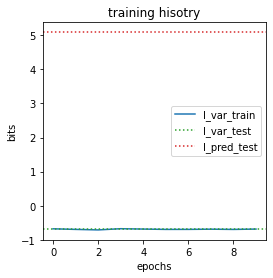

In [11]:
x_train = gb1_single_mutants_df['x']
y_train = gb1_single_mutants_df['y']

# Show training history
print('On test data:')

# Compute likelihood information
I_var, dI_var =  model.I_variational(x=x_train, y=y_train)
print(f'I_var_train: {I_var:.3f} +- {dI_var:.3f} bits') 

# Compute predictive information
I_pred, dI_pred = model.I_predictive(x=x_train, y=y_train)
print(f'I_pred_train: {I_pred:.3f} +- {dI_pred:.3f} bits')

I_var_hist = model.history['I_var']
#val_I_var_hist = model.history['val_I_var']

fig, ax = plt.subplots(1,1,figsize=[4,4])
ax.plot(I_var_hist, label='I_var_train')
#ax.plot(val_I_var_hist, label='I_var_val')
ax.axhline(I_var, color='C2', linestyle=':', label='I_var_test')
ax.axhline(I_pred, color='C3', linestyle=':', label='I_pred_test')
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('bits')
ax.set_title('training hisotry')

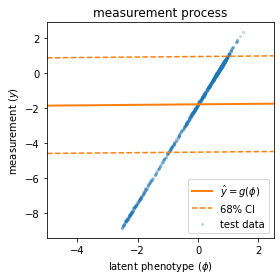

In [12]:
# Compute phi and yhat values
phi = model.x_to_phi(x_train)
yhat = model.phi_to_yhat(phi)

# Create grid for plotting yhat and yqs
phi_lim = [-5, 2.5]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)
yhat_grid = model.phi_to_yhat(phi_grid)
yqs_grid = model.yhat_to_yq(yhat_grid, q=[.16,.84])

# Create two panels
fig, ax = plt.subplots(1, 1, figsize=[4, 4])

# Illustrate measurement process with GE curve
ax.scatter(phi, y_train, color='C0', s=5, alpha=.2, label='test data')
ax.plot(phi_grid, yhat_grid, linewidth=2, color='C1',
        label='$\hat{y} = g(\phi)$')
ax.plot(phi_grid, yqs_grid[:, 0], linestyle='--', color='C1',
        label='68% CI')
ax.plot(phi_grid, yqs_grid[:, 1], linestyle='--', color='C1')
ax.set_xlim(phi_lim)
ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_ylabel('measurement ($y$)')
ax.set_title('measurement process')
ax.legend()

# Fix up plot
fig.tight_layout()
plt.show()